<a href="https://colab.research.google.com/github/inf032/introducaoML/blob/master/Farm05.Avaliacao_Preditores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q shap # Run this if you do not have shap installed

**Importação de Bibliotecas**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics  import mean_squared_error
from sklearn.dummy import DummyRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.impute._base import _BaseImputer

from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('once')

**Classe para imputação e coluna de missing**

In [3]:
class ImputerWithMissingMark (BaseEstimator, TransformerMixin):

    def transformColunas_IMPUTED(self, X) -> pd.DataFrame :
      copia = X.copy()
      for col in self.col_name_with_nan :
          copia[f'{col}{self.postfix}'] = copia[col].isna().astype(int)
      return copia      

    def col_with_nan(self, X) -> list:
      list_col_with_nan = []
      copia = X.copy()
      for col in copia.columns :
        if(copia[col].isna().sum() > 0) :
          list_col_with_nan.append(col)
      return list_col_with_nan

    def col_num_with_nan(self, X) -> list:
      cols = X.shape[1]
      list_col_with_nan = []
      for col in range(cols):    
          if(np.count_nonzero(np.isnan(X[:,col])) > 0) :  
              list_col_with_nan.append(col)
      return list_col_with_nan        

    def __init__(self, imputer=KNNImputer(), postfix = '_IMPUTED'):
      self.imputer = imputer
      self.col_name = None
      self.fitted = False
      self.col_name_with_nan = None
      self.col_number_with_nan = None
      self.postfix = postfix

    def fit_DF(self, X):
      self.col_name = X.columns.values
      self.col_name_with_nan = self.col_with_nan(X)

    def fit_NP(self, X):
      self.col_number_with_nan = self.col_num_with_nan(X)

    def transform_DF(self, X):
      copia = self.transformColunas_IMPUTED(X)
      transformed = pd.DataFrame(self.imputer.transform(copia[self.col_name]))
      transformed.columns = X.columns
      transformed.index = X.index
      for col in self.col_name_with_nan :
        transformed[f'{col}{self.postfix}'] = copia[f'{col}{self.postfix}']
      return transformed

    def transform_NP(self, X):
      transformed = np.copy(X)
      vazio = np.zeros(shape=(X.shape[0], 0))
      for col in self.col_number_with_nan:
        a_nan = [1 if np.isnan(x) else 0 for x in transformed[:,col]]
        vazio = np.append(vazio, np.c_[a_nan], axis = 1)
      transformed = self.imputer.transform(transformed)  
      for col in range(vazio.shape[1]) :
        transformed = np.append(transformed, np.c_[vazio[:, col]], axis = 1)
      return transformed      

    def fit(self, X, y=None):
      if(self.fitted == False) :
        self.fitted = True
        if(type(X) == pd.DataFrame) :
          self.fit_DF(X)
        else :
          self.fit_NP(X)  
        self.imputer.fit(X)
      return self

    def transform(self, X, y=None):
      if(self.fitted == True) :
        if(self.col_name is not None) :
          transformed = self.transform_DF(X)    
        else :
          transformed = self.transform_NP(X)    
        return transformed
      else :
        return X

    def get_params(self, deep=True):
      # retorna um dicionário com os atributos e seus respectivos valores
      return {"imputer": self.imputer, 
              "postfix": self.postfix}
      
    def set_params(self, **parameters):
      # iterando pelos elementos passados e definindo-os na classe
      for parameter, value in parameters.items():
        setattr(self, parameter, value)
      return self 

**Leitura dos Dados**


In [4]:
SEED = 48
np.random.seed(SEED)
warnings.filterwarnings(action='once')

df = pd.read_csv('https://raw.githubusercontent.com/inf032/introducaoML/master/data/farmaco.csv')
df.columns = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K', 'FARMACO']
preditoras = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K']
alvo = 'FARMACO'

X = df[preditoras]
y = df[alvo]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)


print(f'Holdout: {X_train.shape[0]} individuos em treino. {X_test.shape[0]} individuos em teste.')

Holdout: 168 individuos em treino. 57 individuos em teste.


**Definindo pré-processamento e transformadores**

In [5]:
feature_list = ['PA', 'COLESTEROL', 'SEXO', 'IDADE', 'NA_K', 'IDADE_IMPUTED', 'PA_IMPUTED', 'COLESTEROL_IMPUTED', 'NA_K_IMPUTED']

ordinal_transformer = Pipeline(steps=[('ordinal_encoder', OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH'], 
                                                                                     ['LOW', 'NORMAL', 'HIGH']], 
                                                                          handle_unknown='use_encoded_value',
                                                                          unknown_value=np.nan))
                                     ])
onehot_transformer = Pipeline(steps=[('one_hot_encoder',  OneHotEncoder(drop='if_binary', sparse=False))])


col_transformer = ColumnTransformer(transformers=[('pa_colesterol', ordinal_transformer, ['PA', 'COLESTEROL']),
                                                  ('sex', onehot_transformer, ['SEXO'])],
                                    remainder='passthrough')


transformer = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()),
                              ('imputer', ImputerWithMissingMark())])

le = LabelEncoder()

**Ajustando pré-processadores**

In [6]:
le.fit(y_train)

tree = DecisionTreeClassifier(criterion='gini', max_depth=10, 
                              min_samples_leaf = 2, min_samples_split = 3, 
                              random_state=SEED)

modelo = Pipeline(steps=[('transformer', transformer),
                         ('classificador',  tree)])  

modelo.fit(X_train, le.transform(y_train))

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('step_one',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('pa_colesterol',
                                                                   Pipeline(steps=[('ordinal_encoder',
                                                                                    OrdinalEncoder(categories=[['LOW',
                                                                                                                'NORMAL',
                                                                                                                'HIGH'],
                                                                                                               ['LOW',
                                                                                                                'NORMAL',
                                                       

**Calculando o score do modelo original (com todas as features)**


In [7]:
def score_modelo(X_train, y_train, X_test, y_test) :
  tree = DecisionTreeClassifier(criterion='gini', max_depth=10, 
                                min_samples_leaf = 2, min_samples_split = 3, 
                                random_state=SEED)
  le = LabelEncoder()
  le.fit(y_train)
  tree.fit(X_train, le.transform(y_train))
  score_original = tree.score(X_test, le.transform(y_test))
  return X_train.shape[1], score_original

In [8]:
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)
qtde_var_original, score_original = score_modelo(X_train_transformed, y_train, X_test_transformed, y_test)
print(f'Score do modelo com {qtde_var_original} entradas: {np.round(score_original * 100, 5)}%')

Score do modelo com 9 entradas: 96.49123%


**Função de Predição**



In [9]:
def predicao_valor(modelo, idade, pa, colesterol, na_k, sexo) :
  dados_paciente = {'IDADE': [idade], 'PA': [pa] , 'COLESTEROL' : [colesterol], 'NA_K' : [na_k], 'SEXO' : [sexo]}
  dataFrame_paciente = pd.DataFrame(data = dados_paciente)
  predicao = modelo.predict(dataFrame_paciente)[0]
  return predicao

def predicao(modelo, le, idade, pa, colesterol, na_k, sexo) :
  return le.inverse_transform([predicao_valor(modelo, idade, pa, colesterol, na_k, sexo)])[0]

def predicao_prob(modelo, le, idade, pa, colesterol, na_k, sexo) :
  dados_paciente = {'IDADE': [idade], 'PA': [pa] , 'COLESTEROL' : [colesterol], 'NA_K' : [na_k], 'SEXO' : [sexo]}
  dataFrame_paciente = pd.DataFrame(data = dados_paciente)
  predicao = modelo.predict_proba(dataFrame_paciente)[0]
  return predicao[0], predicao[1]

**Exercitando a Função de Probabilidade de Predição**

In [10]:
classe_medA, classe_medB = predicao_prob(modelo, le, 51, 'HIGH', 'NORMAL', 10, 'M')
print(classe_medA, classe_medB )

1.0 0.0


**Exercitando a Função de Predição**

In [11]:
print(predicao(modelo, le, 51, 'HIGH', 'NORMAL', 10, 'M'))
print(predicao(modelo, le, 50, 'HIGH', 'NORMAL', 10, 'M'))

MEDA
MEDB


**Inicializando a biblioteca de [SHAP](https://shap.readthedocs.io/en/latest/index.html) Value**

In [12]:
import shap
shap.initjs() 

explainer = shap.TreeExplainer(model=modelo['classificador'],
                               feature_names=feature_list)
shap_values = explainer.shap_values(X_train_transformed)


/usr/lib/python3.7/importlib/_bootstrap.py:638: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/local/lib/python3.7/dist-packages/cv2/cv2.abi3.so'>
  spec.loader.load_module(spec.name)


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


**Esperança de uma instância ser calculada como MEDA e como MEDB**

> Valor que o modelo escolhe para MEDA / MEDB se não souber nada sobre o paciente



In [13]:
explainer.expected_value

array([0.55357143, 0.44642857])

**Analisando as predições do conjunto de treinamento**

In [14]:
valor = 0
shap.initjs() 
shap_values = explainer.shap_values(X_train_transformed)
shap.force_plot(explainer.expected_value[valor], 
                shap_values[valor], X_train_transformed, feature_names=feature_list)


**Explicando uma predição**

In [15]:
idade = 24
pa = 'LOW'
colesterol = 'LOW'
na_k = 30
sexo = 'M'
dados_paciente = {'IDADE': [idade], 'PA': [pa] , 'COLESTEROL' : [colesterol], 'NA_K' : [na_k], 'SEXO' : [sexo]}
dataFrame_paciente = pd.DataFrame(data = dados_paciente)
predicao_valor = modelo.predict(dataFrame_paciente)[0]
data_paciente_transformed = modelo['transformer'].transform(dataFrame_paciente)
print(f'Predição: {le.inverse_transform(modelo.predict(dataFrame_paciente))}')

Predição: ['MEDA']


In [16]:
shap.initjs() 
shap_values = explainer.shap_values(data_paciente_transformed)
shap.force_plot(explainer.expected_value[predicao_valor], shap_values[predicao_valor][0,:], data_paciente_transformed[0,:], feature_names=feature_list)


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


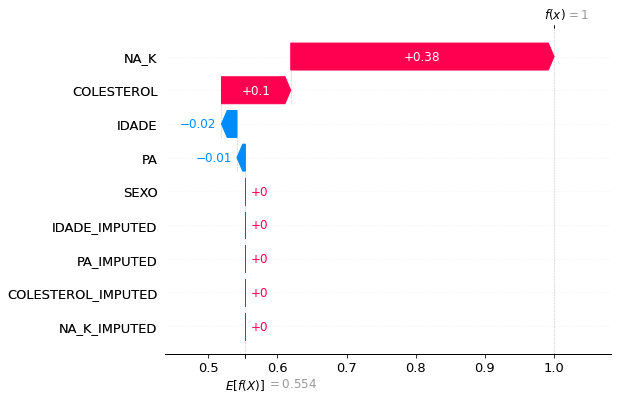

In [17]:
shap.plots._waterfall.waterfall_legacy(expected_value=explainer.expected_value[predicao_valor],
                                       shap_values=shap_values[predicao_valor][0,:], show=True, feature_names=feature_list)

**Gráfico Resumo indicando as features com maior SHAP Value**

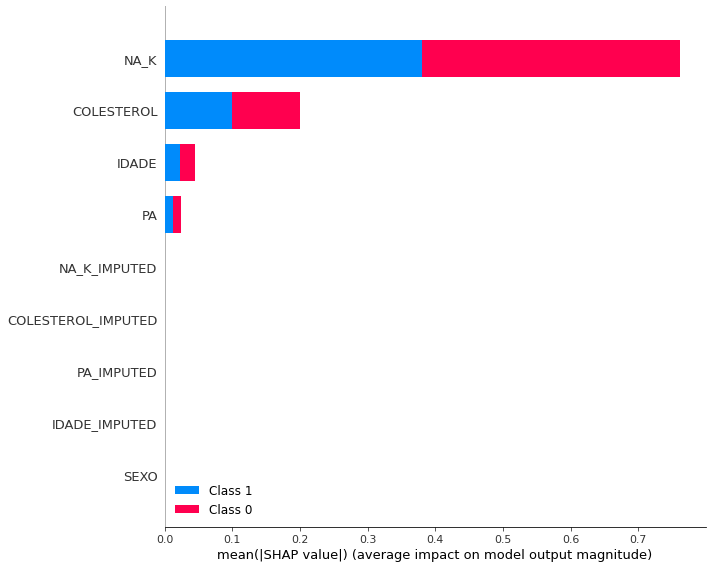

In [18]:
shap.summary_plot(shap_values, features=X_train_transformed, feature_names=feature_list, plot_type='bar', plot_size=(10,8))

**Avaliando a contribuição das features pra predição de MEDA**

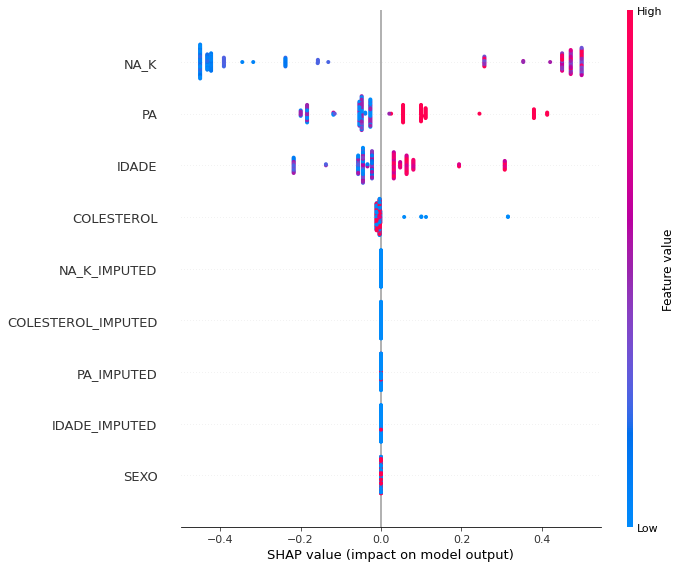

In [19]:
shap_values = explainer.shap_values(X_train_transformed)
shap.summary_plot(shap_values[0], X_train_transformed, feature_names=feature_list, plot_type="dot", plot_size=(10,8));

**Avaliando a contribuição de uma feature pra predição de MEDA**

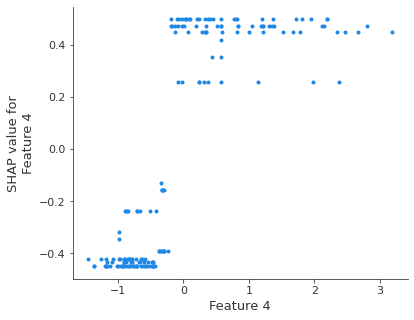

In [20]:
shap.dependence_plot(feature_list.index('NA_K'), shap_values[0], X_train_transformed, interaction_index=None)

**Avaliando a contribuição e correlação de mais de uma feature pra predição de MEDA**

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


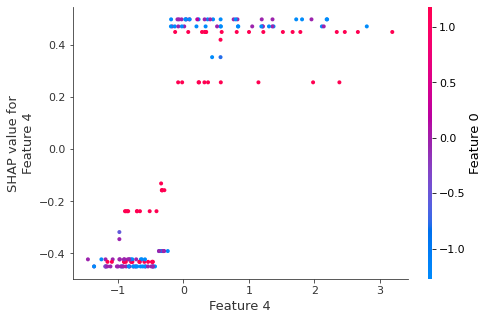

In [21]:
shap.dependence_plot(feature_list.index('NA_K'), shap_values[0], X_train_transformed, interaction_index=feature_list.index('PA'))